##### Malwina Wojewoda
# 2.2. AE2: Wypełnianie koła prostokątami 
Rozwiązać wariant problemu znanego w literaturze jako cutting stock problem.

Mamy dane koło o promieniu r oraz zbiór dostępnych prostokątów zadanych przez trzy liczby: wysokość, szerokość i wartość.

Celem jest ułożenie prostokątów w kole tak, aby zmaksymalizować sumę ich wartości, spełniając następujące warunki:

boki wszystkich prostokątów były równoległe do osi układu,
wnętrza prostokątów nie miały części wspólnej (intuicyjnie: prostokąty nie nachodzą na siebie, ale mogą się stykać bokami),
każdy prostokąt można wstawić dowolnie wiele razy.
Zaproponować kodowanie problemu, operator mutacji i krzyżowania i zaimplementować algorytm genetyczny rozwiązujący powyższy problem.

Przetestować rozwiązanie na danych dostarczonych w pliku http://pages.mini.pw.edu.pl/~karwowskij/mioad/cutting.tar.xz.

Struktura pliku: w nazwie pliku jest podany promień koła, plik jest w formacie csv: pierwsza kolumna to szerokość prostokąta, druga to wysokość, trzecia to wartość prostokąta.

Minimalny wynik na 4 punkty to przynajmniej wartość sumaryczna prostokątów:
* 30000 w kole o średnicy 800, 
* 17500 w kole o średnicy 1000, 
* 25000 w kole o średnicy 1100,
* 30000 w kole o średnicy 1200.

Zbiór r850 nie wpływa na punktację, ale należy zaprezentować wynik dla niego.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy, copy
import itertools
import random
from operator import attrgetter
random.seed(777)

In [2]:
class Rectangle:

    def __init__(self, top_right_x, top_right_y, rectangle_type=[0, 0, 0]):
        self.width = rectangle_type[0]
        self.height = rectangle_type[1]
        self.value = rectangle_type[2]
        self.top_right_x = top_right_x
        self.top_right_y = top_right_y
        self.bottom_left_x = self.top_right_x - self.width 
        self.bottom_left_y = self.top_right_y - self.height

    def intersects(self, other):
        return not (self.top_right_x < other.bottom_left_x or self.bottom_left_x > other.top_right_x or self.top_right_y < other.bottom_left_y or self.bottom_left_y > other.top_right_y)

    def is_in_circle(self, radius):
        if (self.top_right_x)**2 + (self.top_right_y)**2 > radius**2: #1st quarter
            return False
        if (self.bottom_left_x)**2 + (self.top_right_y)**2 > radius**2: #2nd quarter
            return False
        if (self.bottom_left_x)**2 + (self.bottom_left_y)**2 > radius**2: #3rd quarter
            return False
        if (self.top_right_x)**2 + (self.bottom_left_y)**2 > radius**2: #4th quarter
            return False
        return True 

In [3]:
class CircleWithRectangles:

    def __init__(self, rectangles_list, radius):
        self.rectangles_list = rectangles_list
        self.score = 0
        self.radius = radius
    
    def calculate_score(self):
        self.score = sum(rectangle.value for rectangle in self.rectangles_list)
    
    # def check(self):
    #     for rect1, rect2 in itertools.combinations(self.rectangles_list, 2):
    #         if rect1.intersects(rect2)
    
    def plot_circle(self):
        circle = plt.Circle((0, 0), self.radius, color='#4d004d', fill=False)
        fig, ax = plt.subplots()

        plt.xlim(-self.radius, self.radius)
        plt.ylim(-self.radius, self.radius)
        ax.tick_params(axis='both', which='both', labelbottom=False, bottom=False, left=False, labelleft=False)
        ax.set_aspect(1)
        ax.add_artist(circle)

        for rect in self.rectangles_list:
            rectangle = patches.Rectangle((rect.bottom_left_x, rect.bottom_left_y), rect.width, rect.height, linewidth=1, edgecolor='#4d004d', facecolor='#e6ccff', alpha=0.5)
            ax.add_patch(rectangle)
        plt.show() 
    

In [4]:
def get_rectangles_types(radius):
    rectangles = pd.read_csv('./../data/cutting/r'+str(radius)+'.csv', header=None)
    rectangles.columns = ['width', 'height', 'value']
    rectangles_rotated = rectangles.copy()
    rectangles_rotated.columns = ['height', 'width', 'value']
    all_rectangles_types = pd.concat([rectangles, rectangles_rotated])
    all_rectangles_types.loc[(all_rectangles_types.value / (all_rectangles_types.width * all_rectangles_types.height)).sort_values(ascending=False).index]
    all_rectangles_types.reset_index(drop=True, inplace=True)
    return all_rectangles_types

In [5]:
rectangles_types = get_rectangles_types(1200)

# Inicjalizacja

In [6]:
def initialize_circle_with_rectangles(rectangle_type, radius):
    rectangles_list = []
    width = rectangle_type[0]
    height = rectangle_type[1]

    x_n = radius//width
    y_n = radius//height

    for y in range(1, y_n+1):
        for x in range(1, x_n+1): 
            rectangle_top_right = Rectangle(x*width, y*height, rectangle_type)
            rectangle_top_left = Rectangle(-(x-1)*width, y*height, rectangle_type)
            rectangle_bottom_left = Rectangle(-(x-1)*width, -(y-1)*height, rectangle_type)
            rectangle_bottom_right = Rectangle(x*width, -(y-1)*height, rectangle_type)

            if rectangle_top_right.is_in_circle(radius):
                rectangles_list.append(rectangle_top_right)
                rectangles_list.append(rectangle_top_left)
                rectangles_list.append(rectangle_bottom_left)
                rectangles_list.append(rectangle_bottom_right)
            else:
                break
    
    return CircleWithRectangles(rectangles_list, radius)

In [7]:
def initialize_population(rectangles_types, radius):
    population = []
    for i in range(len(rectangles_types)):
        population.append(initialize_circle_with_rectangles(rectangles_types.loc[i, :].values.tolist(), radius)) 
    return population

In [8]:
population = initialize_population(rectangles_types, 1200)

In [9]:
for circle in population:
    circle.calculate_score()

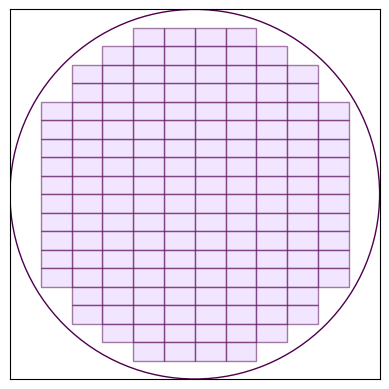

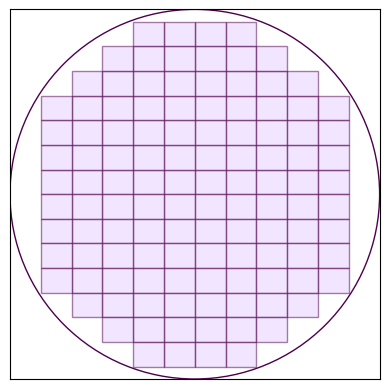

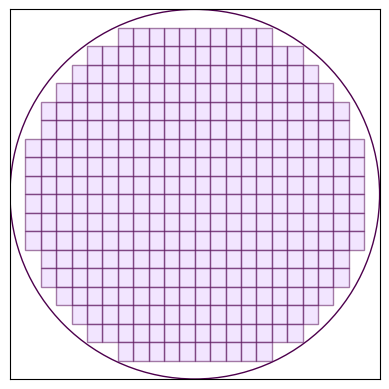

In [10]:
population[0].plot_circle()
population[1].plot_circle()
population[3].plot_circle()

# Warunek stopu

In [11]:
best_circle = max(population, key=attrgetter('score'))

In [12]:
epochs_without_improvement = 0
best_circle_new = max(population, key=attrgetter('score'))
if best_circle_new.score > best_circle.score:
    best_circle = best_circle_new
else:
    epochs_without_improvement += 1
    if epochs_without_improvement > 5:
        print('The algorithm did not improve after 5 epochs, so it was stopped at epoch {}. The best circle was saved.'.format(epoch))
        reak

# Krzyżowanie

In [13]:
rectangles_in_circle_1 = population[0].rectangles_list
rectangles_in_circle_2 = population[2].rectangles_list
mutated = [rectangle for rectangle in rectangles_in_circle_1 if rectangle.top_right_y > 400]
mutated.extend([rectangle for rectangle in rectangles_in_circle_2 if rectangle.top_right_y <= 400])

In [14]:
mutated_circle = CircleWithRectangles(mutated, 1200)

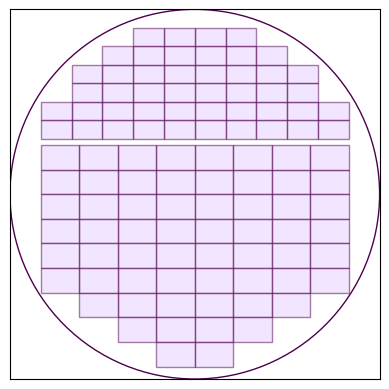

In [15]:
mutated_circle.plot_circle()

In [286]:
radius = 1200
def crossover():
    circle_ix = random.sample(range(0, len(population)), 2)
    circle_1 = population[circle_ix[0]].rectangles_list
    circle_2 = population[circle_ix[1]].rectangles_list

    crossover_point = random.randrange(-radius+100, radius-100, 10) # 100 to make a difference
    is_vertical = bool(random.getrandbits(1))
    if is_vertical:
        mutated = [rectangle for rectangle in circle_1 if rectangle.top_right_x < crossover_point]
        mutated.extend([rectangle for rectangle in circle_2 if rectangle.bottom_left_x >= crossover_point])
        mutated.extend(fill_space_after_crossover(circle_1, circle_2, is_vertical, crossover_point))
    else:
        mutated = [rectangle for rectangle in circle_1 if rectangle.top_right_y < crossover_point]
        mutated.extend([rectangle for rectangle in circle_2 if rectangle.bottom_left_y >= crossover_point])
        mutated.extend(fill_space_after_crossover(circle_1, circle_2, is_vertical, crossover_point))
    
    return CircleWithRectangles(mutated, radius)

In [287]:
def fill_space_after_crossover(circle_1, circle_2, is_vertical, crossover_point):
    rectangles_to_fill = []
    if is_vertical:
        max_right_x = float('-inf') 
        for rectangle in circle_1:
            if rectangle.top_right_x < crossover_point and rectangle.top_right_x > max_right_x:
                max_right_x = rectangle.top_right_x
                
        min_left_x = float('inf')
        for rectangle in circle_2:
            if rectangle.bottom_left_x >= crossover_point and rectangle.bottom_left_x < min_left_x:
                min_left_x = rectangle.bottom_left_x

        min_width_in_set = rectangles_types.loc[rectangles_types['width'].idxmin(), :].values.tolist()[0]
        print(min_width_in_set)
        print(min_left_x - max_right_x)
        if min_width_in_set <= min_left_x - max_right_x:
            max_width_that_fits = max(rectangles_types.loc[rectangles_types['width'] <= min_left_x - max_right_x,  'width'])
            if min_left_x - max_right_x >= max_width_that_fits:
                min_rect_type = rectangles_types.loc[rectangles_types['width'] == max_width_that_fits].head(1).iloc[0]
                height = min_rect_type[1]
                y_n = radius//height
                for y in range(-y_n, y_n+1):
                    rectangle_to_fill = Rectangle(min_left_x, y*height, min_rect_type)
                    print(rectangle_to_fill.__dict__)
                    if rectangle_to_fill.is_in_circle(radius):
                        rectangles_to_fill.append(rectangle_to_fill)
    else:
        max_upper_y = float('-inf') 
        for rectangle in circle_1:
            if rectangle.top_right_y < crossover_point and rectangle.top_right_y > max_upper_y:
                max_upper_y = rectangle.top_right_y
                
        min_bottom_y = float('inf')
        for rectangle in circle_2:
            if rectangle.bottom_left_y >= crossover_point and rectangle.bottom_left_y < min_bottom_y:
                min_bottom_y = rectangle.bottom_left_y
        
        min_height_in_set = rectangles_types.loc[rectangles_types['height'].idxmin(), :].values.tolist()[1]
        print(min_height_in_set)
        print(min_bottom_y - max_upper_y)
        if min_height_in_set <= min_bottom_y - max_upper_y:
            max_height_that_fits = max(rectangles_types.loc[rectangles_types['height'] <= min_bottom_y - max_upper_y,  'height'])
            if min_bottom_y - max_upper_y >= max_height_that_fits:
                min_rect_type = rectangles_types.loc[rectangles_types['height'] == max_height_that_fits].head(1).iloc[0].values.tolist()
                width = min_rect_type[0]
                x_n = radius//width
                for x in range(-x_n, x_n+1):
                    rectangle_to_fill = Rectangle(x*width, min_bottom_y, min_rect_type)
                    print(rectangle_to_fill.__dict__)
                    if rectangle_to_fill.is_in_circle(radius):
                        rectangles_to_fill.append(rectangle_to_fill)
    return rectangles_to_fill

In [290]:
new_circle = crossover()

100
200
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y': -1200, 'bottom_left_x': 600, 'bottom_left_y': -1320}
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y': -1080, 'bottom_left_x': 600, 'bottom_left_y': -1200}
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y': -960, 'bottom_left_x': 600, 'bottom_left_y': -1080}
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y': -840, 'bottom_left_x': 600, 'bottom_left_y': -960}
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y': -720, 'bottom_left_x': 600, 'bottom_left_y': -840}
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y': -600, 'bottom_left_x': 600, 'bottom_left_y': -720}
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y': -480, 'bottom_left_x': 600, 'bottom_left_y': -600}
{'width': 200, 'height': 120, 'value': 200, 'top_right_x': 800, 'top_right_y'

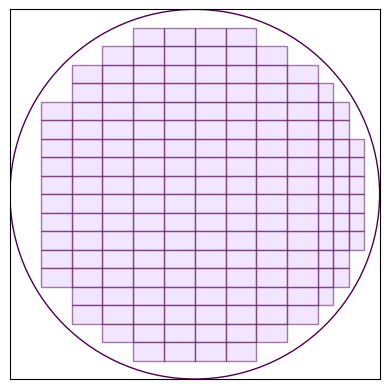

In [291]:
new_circle.plot_circle()